<a href="https://colab.research.google.com/github/ngkarthi71/colon-cancer-analysis/blob/final_task_two/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2

In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
!ls /content/drive/'My Drive'/CML-Assignment2/

cell_model_VGG_3   Image_classification_data.zip
Final_Task1.ipynb  latest.ipynb


In [169]:
!cp /content/drive/'My Drive'/CML-Assignment2/Image_classification_data.zip .
!unzip -q -o Image_classification_data.zip
!rm Image_classification_data.zip
!ls

cell_model_VGG_3	   drive      patch_images	   sample_data
data_labels_extraData.csv  __MACOSX   predict_celltype
data_labels_mainData.csv   model.png  predict_celltype.h5


# Importing the needed packages for solving this problem

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2 as cv

import IPython.display as display
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skimage.io import imread
from skimage.transform import resize

import warnings;
warnings.simplefilter('ignore')




In [171]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

2.5.0


In [172]:
cancer=pd.read_csv('data_labels_mainData.csv')

In [173]:
cancer.head(5)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


### Randomly split the given data set

In [174]:
train_data, test_data = train_test_split(cancer, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


# Data Exploration

In [175]:
cancer.dtypes

InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object

In [176]:
cancer.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

In [177]:
cancer.cellType.value_counts()

2    4079
1    2543
0    1888
3    1386
Name: cellType, dtype: int64

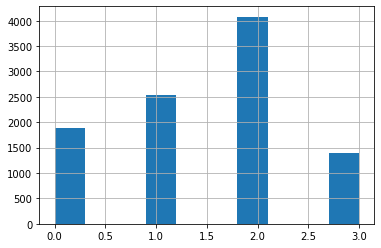

In [178]:
cancer.cellType.hist()
plt.show()

# Model Development

Text(0, 0.5, 'other')

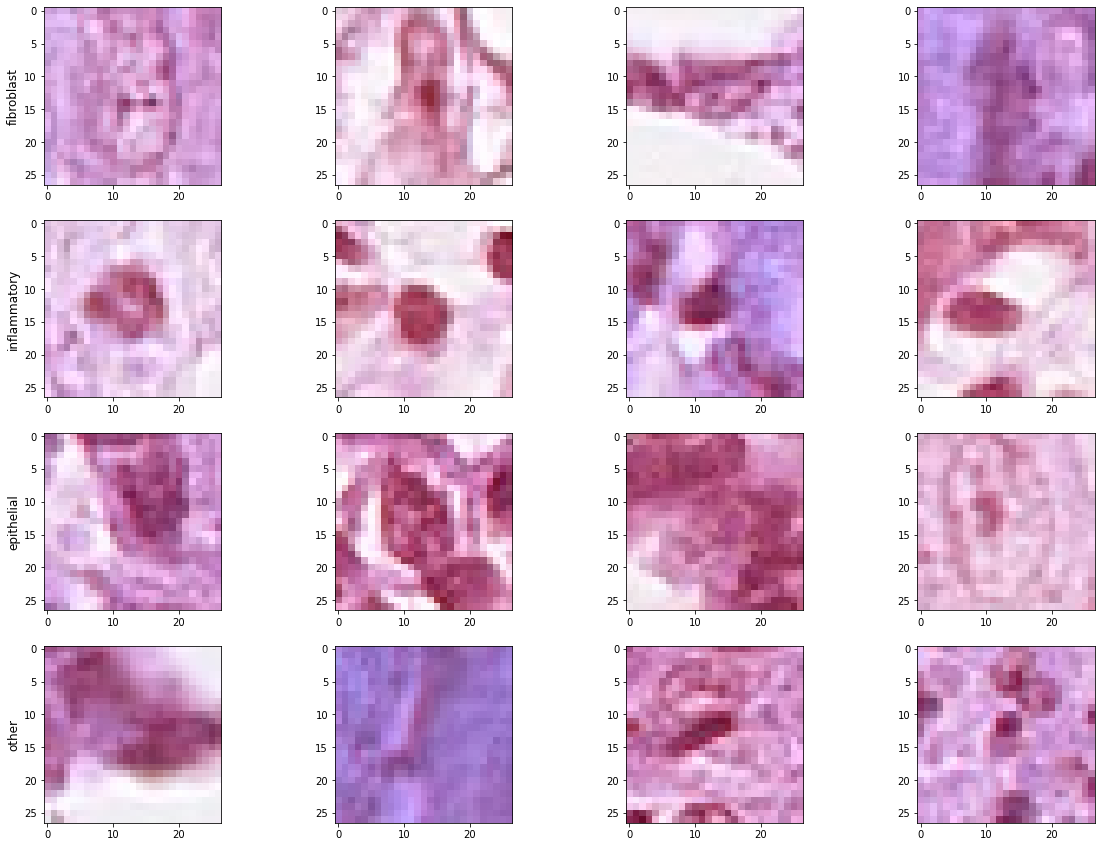

In [179]:
#'fibroblast': 0, 'inflammatory':1, 'epithelial': 2, 'others':3

fibroblast = cancer.loc[cancer['cellType'] == 0].sample(4)
inflammatory = cancer.loc[cancer['cellType'] == 1].sample(4)
epithelial = cancer.loc[cancer['cellType'] == 2].sample(4)
others = cancer.loc[cancer['cellType'] == 3].sample(4)

fibroblast_images = []
inflammatory_images = []
epithelial_images = []
other_images = []

for path in fibroblast['ImageName']:
    image_path = "/content/patch_images/" + path
    image = cv.imread(image_path)
    fibroblast_images.append(image)
    
for path in inflammatory['ImageName']:
    image_path = "/content/patch_images/" + path
    image = cv.imread(image_path)
    inflammatory_images.append(image)
    
for path in epithelial['ImageName']:
    image_path = "/content/patch_images/" + path
    image = cv.imread(image_path)
    epithelial_images.append(image)

for path in others['ImageName']:
    image_path = "/content/patch_images/" + path
    image = cv.imread(image_path)
    other_images.append(image)    
fig,axis = plt.subplots(4,4,figsize=(20,15))
for i, image in enumerate(fibroblast_images):
    axis[0,i].imshow(image)
axis[0,0].set_ylabel('fibroblast', size='large')

for i, image in enumerate(inflammatory_images):
    axis[1,i].imshow(image)
axis[1,0].set_ylabel('inflammatory', size='large')

for i, image in enumerate(epithelial_images):
    axis[2,i].imshow(image)
axis[2,0].set_ylabel('epithelial', size='large')

for i, image in enumerate(other_images):
    axis[3,i].imshow(image)
axis[3,0].set_ylabel('other', size='large')

## Stochastic Gradient Descent model - Traditional machine learning algorithm

In [180]:
# flattening images into image array in order to proceed with the algorithm
flat_data_arr=[]
target_arr=[]

for img in cancer['ImageName']:
    path = '/content/patch_images/' + img
    image_arr = cv.imread(path)
    img_resized=resize(image_arr,(27, 27, 3))
    flat_data_arr.append(img_resized.flatten())
    target_arr.append(cancer.loc[cancer['ImageName'] == img].cellType)
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data_arr)
df['Target']=target
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181,2182,2183,2184,2185,2186,Target
0,0.929412,0.835294,0.949020,0.913725,0.819608,0.937255,0.898039,0.803922,0.921569,0.890196,0.792157,0.913725,0.929412,0.827451,0.949020,0.945098,0.839216,0.960784,0.941176,0.831373,0.956863,0.925490,0.811765,0.941176,0.905882,0.784314,0.917647,0.886275,0.764706,0.894118,0.858824,0.733333,0.870588,0.858824,0.737255,0.874510,0.854902,0.733333,0.874510,0.854902,...,0.803922,0.647059,0.843137,0.847059,0.690196,0.886275,0.909804,0.749020,0.937255,0.925490,0.760784,0.949020,0.909804,0.745098,0.933333,0.921569,0.756863,0.949020,0.945098,0.780392,0.972549,0.941176,0.776471,0.972549,0.913725,0.745098,0.941176,0.874510,0.705882,0.901961,0.760784,0.592157,0.788235,0.686275,0.517647,0.709804,0.745098,0.576471,0.764706,0
1,0.827451,0.686275,0.866667,0.827451,0.686275,0.878431,0.858824,0.721569,0.913725,0.854902,0.717647,0.901961,0.921569,0.784314,0.964706,1.000000,0.858824,1.000000,0.925490,0.776471,0.949020,0.894118,0.733333,0.905882,0.847059,0.682353,0.854902,0.874510,0.705882,0.874510,0.890196,0.733333,0.890196,0.870588,0.729412,0.878431,0.803922,0.682353,0.815686,0.850980,...,0.898039,0.784314,0.984314,0.925490,0.811765,0.992157,0.901961,0.811765,0.984314,0.866667,0.796078,0.960784,0.894118,0.819608,0.976471,0.945098,0.866667,1.000000,0.972549,0.886275,1.000000,0.949020,0.858824,0.980392,0.921569,0.831373,0.952941,0.937255,0.843137,0.968627,0.905882,0.811765,0.941176,0.933333,0.835294,0.968627,0.956863,0.858824,0.992157,0
2,0.968627,0.952941,0.968627,0.964706,0.949020,0.972549,0.956863,0.937255,0.968627,0.945098,0.917647,0.960784,0.949020,0.909804,0.960784,0.952941,0.894118,0.956863,0.933333,0.858824,0.933333,0.905882,0.815686,0.898039,0.854902,0.737255,0.835294,0.827451,0.686275,0.796078,0.815686,0.650980,0.772549,0.807843,0.623529,0.756863,0.776471,0.584314,0.725490,0.772549,...,0.713725,0.462745,0.647059,0.705882,0.435294,0.627451,0.721569,0.443137,0.639216,0.717647,0.431373,0.631373,0.705882,0.415686,0.619608,0.682353,0.384314,0.592157,0.584314,0.290196,0.498039,0.619608,0.325490,0.537255,0.643137,0.356863,0.568627,0.619608,0.341176,0.552941,0.686275,0.419608,0.635294,0.784314,0.529412,0.745098,0.764706,0.529412,0.745098,0
3,0.949020,0.949020,0.952941,0.945098,0.945098,0.952941,0.945098,0.945098,0.952941,0.949020,0.949020,0.952941,0.952941,0.949020,0.952941,0.956863,0.952941,0.956863,0.956863,0.952941,0.956863,0.956863,0.952941,0.956863,0.952941,0.949020,0.952941,0.952941,0.945098,0.952941,0.952941,0.945098,0.952941,0.956863,0.945098,0.952941,0.956863,0.945098,0.952941,0.960784,...,0.909804,0.858824,0.933333,0.886275,0.831373,0.909804,0.913725,0.858824,0.937255,0.956863,0.898039,0.976471,0.949020,0.890196,0.972549,0.937255,0.866667,0.952941,0.913725,0.831373,0.929412,0.945098,0.850980,0.952941,0.960784,0.850980,0.960784,0.949020,0.827451,0.945098,0.956863,0.827451,0.949020,0.988235,0.854902,0.972549,0.866667,0.729412,0.847059,0
4,0.741176,0.509804,0.741176,0.721569,0.494118,0.729412,0.717647,0.494118,0.733333,0.729412,0.509804,0.745098,0.776471,0.568627,0.792157,0.784314,0.603922,0.811765,0.788235,0.627451,0.823529,0.756863,0.580392,0.788235,0.662745,0.458824,0.686275,0.721569,0.501961,0.713725,0.874510,0.650980,0.839216,0.850980,0.627451,0.803922,0.878431,0.650980,0.835294,0.858824,...,0.960784,0.929412,0.964706,0.976471,0.952941,0.984314,0.972549,0.949020,0.976471,0.964706,0.945098,0.972549,0.952941,0.933333,0.960784,0.952941,0.933333,0.960784,0.949020,0.937255,0.956863,0.941176,0.937255,0.952941,0.937255,0.933333,0.949020,0.941176,0.937255,0.952941,0.945098,0.937255,0.952941,0.949020,0.937255,0.956863,0.956863,0.941176,0.956863,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [181]:
# Train test split of image array
x=df.iloc[:,:-1]
y=df.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=77,stratify=y)

# Building an image classfier model using SGDClassifier

In [182]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(loss='hinge', random_state=42)
sgd_clf.fit(x_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [183]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring='accuracy')

array([0.57938613, 0.63129973, 0.55761941])

In [184]:
score = sgd_clf.score(x_test, y_test)
score

0.6111111111111112

## Fine tuning the model in order to get better accuracy¶

In [185]:
sgd_clf = SGDClassifier(loss='log', random_state=42, 
                        penalty='l2', alpha=1e-4)
sgd_clf.fit(x_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [186]:
cross_val_score(sgd_clf, x_train, y_train, cv=7, scoring='accuracy')

array([0.64721485, 0.65782493, 0.57206012, 0.66843501, 0.65251989,
       0.67462423, 0.59026549])

In [187]:
score = sgd_clf.score(x_test, y_test)
score

0.6257575757575757

## Function definition for plotting the graph


In [188]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

# Classic Neural Network model

In [189]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [190]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.5.0'

In [191]:


model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [192]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 2187)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 256)               560128    
_________________________________________________________________
dense_45 (Dense)             (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


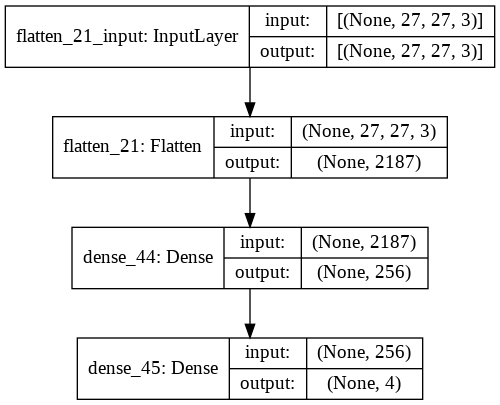

In [193]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [194]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [195]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')
from tensorflow.keras.preprocessing.image import ImageDataGenerator


cell_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
cell_val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

cell_train_generator = cell_train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cell_validation_generator = cell_val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [196]:
cell_history = model.fit_generator(cell_train_generator, validation_data = cell_validation_generator, epochs=150,verbose=0)

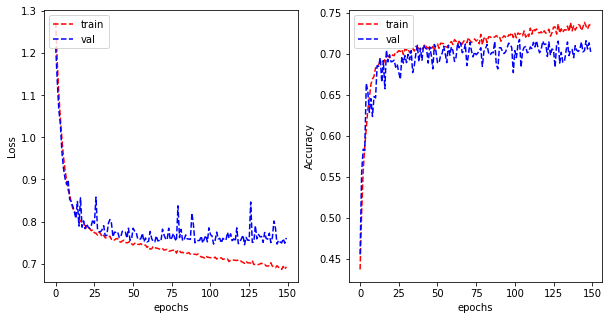

In [197]:
plot_learning_curve(cell_history.history['loss'], cell_history.history['val_loss'], 
                    cell_history.history['categorical_accuracy'], cell_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

# Testing 

In [198]:
test_data['cellType'] = test_data['cellType'].astype('str')

cell_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

cell_test_generator = cell_test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


In [199]:
model.evaluate(cell_test_generator)

1980/1980 [==============================] - 4s 2ms/step - loss: 0.8100 - categorical_accuracy: 0.7071


[0.8099802136421204, 0.7070707082748413]

In [200]:
label_names = {'fibroblast': 0, 'inflammatory':1, 'epithelial': 2, 'others':3}

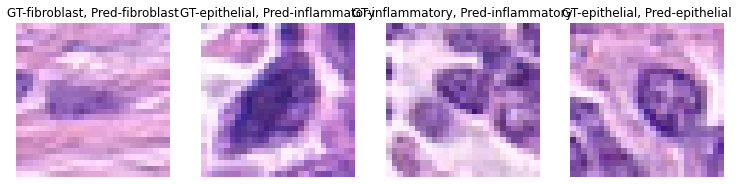

In [201]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in cell_test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [202]:
model.save("predict_celltype")

INFO:tensorflow:Assets written to: predict_celltype/assets


# Lenet model - Predicting CellType

In [203]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [204]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

cell_type_train_datagen = ImageDataGenerator(
                                rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

cell_type_val_datagen = ImageDataGenerator(
                                rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

batch_size = 32
cell_type_train_generator = cell_type_train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cell_type_validation_generator = cell_type_val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [205]:
reg_lambda = 0.001

cell_type_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
  
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(48, (5, 5), padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [206]:
cell_type_model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 27, 27, 32)        2432      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 9, 9, 48)          38448     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 4, 4, 48)          0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 768)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 256)               196864    
_________________________________________________________________
dense_47 (Dense)             (None, 84)              

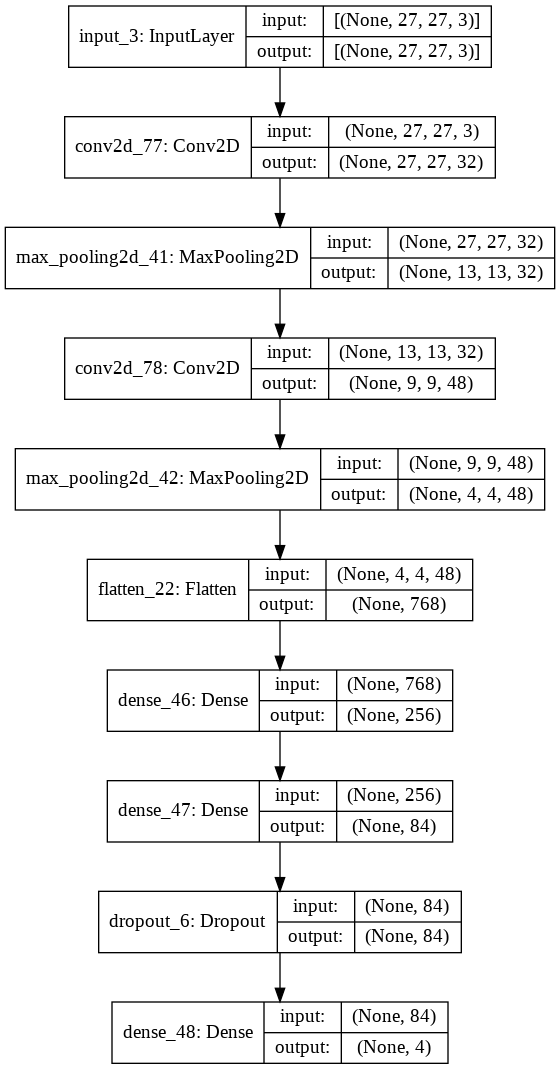

In [207]:
tf.keras.utils.plot_model(cell_type_model, show_shapes=True)

In [208]:
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
cell_type_model .compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [209]:
history = cell_type_model.fit_generator(cell_type_train_generator, 
                                    validation_data = cell_type_validation_generator, 
                                    epochs=150,verbose=0)

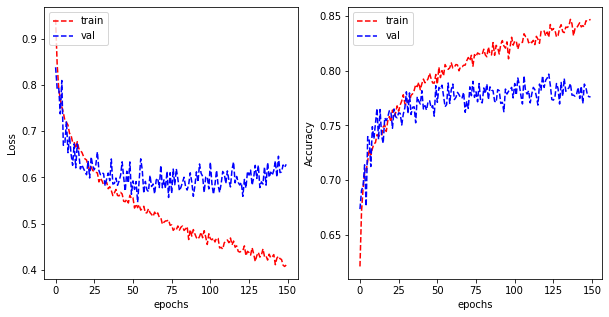

In [210]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Fine tune the model

In [211]:
reg_lambda = 0.001

cell_type_model_reg = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
  
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(48, (5, 5), padding='valid', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), padding='valid', activation='relu',),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

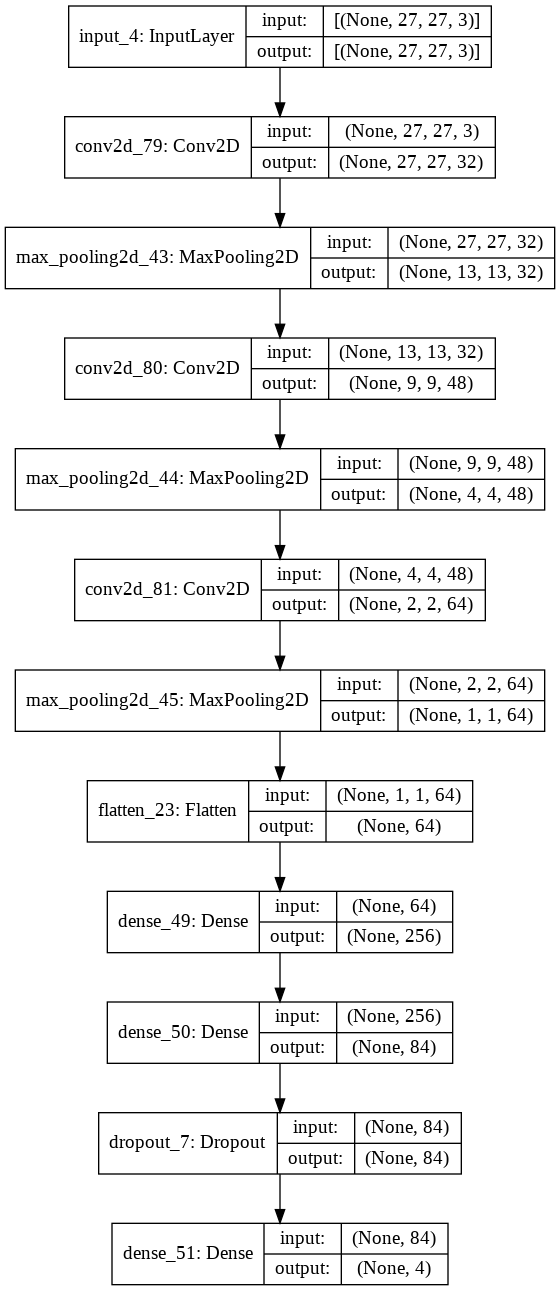

In [212]:
tf.keras.utils.plot_model(cell_type_model_reg, show_shapes=True)

In [213]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
cell_type_model_reg.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [214]:
cell_history_reg = cell_type_model_reg.fit_generator(cell_type_train_generator, 
                                    validation_data = cell_type_validation_generator, 
                                    epochs=100,verbose=0)

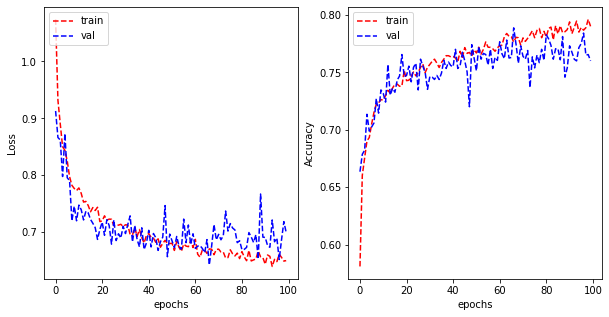

In [215]:
plot_learning_curve(cell_history_reg.history['loss'], cell_history_reg.history['val_loss'], 
                    cell_history_reg.history['categorical_accuracy'], cell_history_reg.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [216]:
cell_type_model_reg.save("predict_celltype.h5")

# Testing the model accuracy

In [217]:
test_data['cellType'] = test_data['cellType'].astype('str')

cell_test_datagen = ImageDataGenerator(                               
                                rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

batch_size = 1

cell_test_generator = cell_test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='/content/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


In [218]:
cell_model = load_model('predict_celltype.h5')
cell_model.evaluate(cell_test_generator)

1980/1980 [==============================] - 6s 3ms/step - loss: 0.7229 - categorical_accuracy: 0.7540


[0.7228953242301941, 0.7540404200553894]

In [219]:
label_names = {'fibroblast': 0, 'inflammatory':1, 'epithelial': 2, 'others':3}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


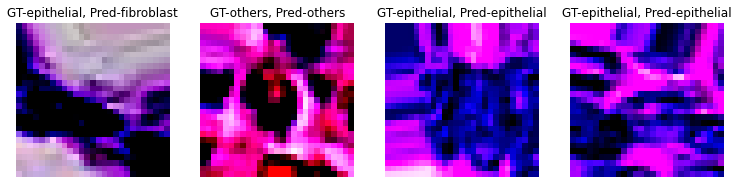

In [220]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in cell_test_generator:
        batches = batches + 1
        y_hat = cell_model.predict(x, verbose=0)
        
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])]))
        else:
            break
        
        plt.axis('off')

# VGG Model- Predict Cell Type

In [221]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [222]:
cell_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [223]:
cell_model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_24 (Flatten)         (None, 2187)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 256)               560128    
_________________________________________________________________
dense_53 (Dense)             (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


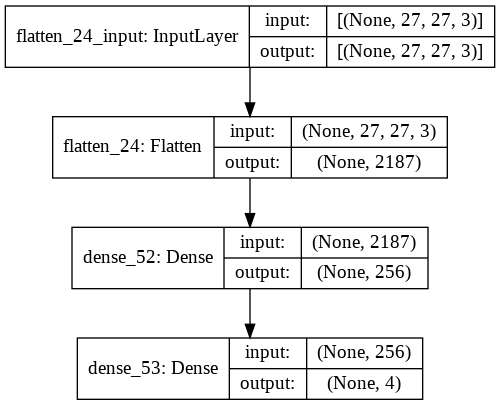

In [224]:
tf.keras.utils.plot_model(cell_model, show_shapes=True)

In [225]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')
from tensorflow.keras.preprocessing.image import ImageDataGenerator


cell_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
cell_val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

cell_train_generator = cell_train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cell_validation_generator = cell_val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


## Baseline Model

In [226]:
cell_model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [227]:
cell_model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [228]:
cell_history = cell_model_VGG_1.fit_generator(cell_train_generator, validation_data = cell_validation_generator, epochs=25,verbose=0)

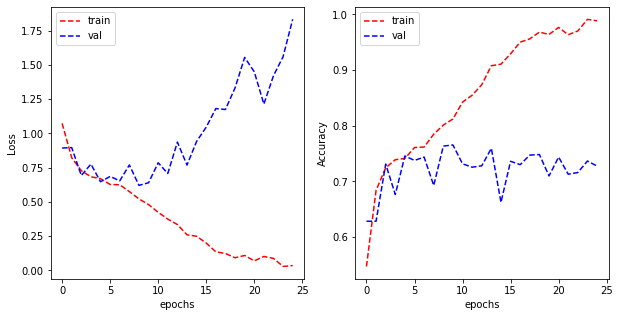

In [229]:
plot_learning_curve(cell_history.history['loss'], cell_history.history['val_loss'], 
                    cell_history.history['categorical_accuracy'], cell_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Due to Overfitting we have to apply Regularisation, dropout and Augmentation techniques to achieve High accuracy with minimum loss.

## Regularisation

In [230]:
reg_lambda = 0.001

cell_model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [231]:
cell_model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

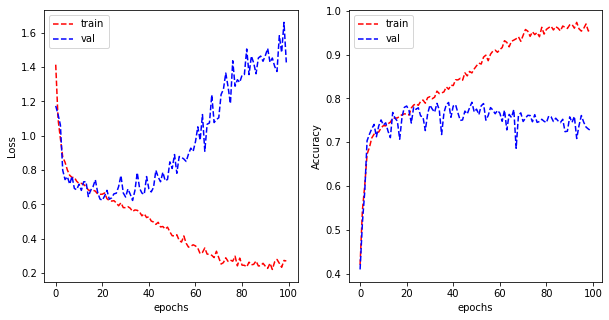

In [232]:
history_VGG_2 = cell_model_VGG_2.fit_generator(cell_train_generator, validation_data = cell_validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Data Augmentation

In [233]:

train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')
from tensorflow.keras.preprocessing.image import ImageDataGenerator
cell_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
cell_val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

cell_train_generator = cell_train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cell_validation_generator = cell_val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')




Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [234]:
reg_lambda = 0.001

cell_model_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [235]:
cell_model_VGG_3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

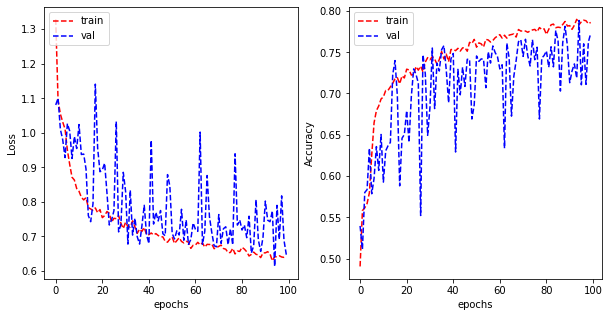

In [236]:
cell_history_VGG_3 = cell_model_VGG_3.fit_generator(cell_train_generator, validation_data = cell_validation_generator, epochs=100, verbose=0)

plot_learning_curve(cell_history_VGG_3.history['loss'], cell_history_VGG_3.history['val_loss'], 
                    cell_history_VGG_3.history['categorical_accuracy'], cell_history_VGG_3.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [237]:
cell_model_VGG_3.summary()
    

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 6, 6, 128)       

# Save the Model

In [238]:
cell_model_VGG_3.save("cell_model_VGG_3")

INFO:tensorflow:Assets written to: cell_model_VGG_3/assets


In [239]:
!cp -R ./cell_model_VGG_3 /content/drive/'My Drive'/CML-Assignment2/

## Test Our model 

In [240]:
test_data['cellType'] = test_data['cellType'].astype('str')
batch_size = 1
cell_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')



cell_test_generator = cell_test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = cell_test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in cell_test_generator:
        y_hat = cell_model_VGG_3.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))



Found 1980 validated image filenames belonging to 4 classes.
Accuracy score:  0.7742424242424243
F1 score:  0.7296347164149486
[[305  36  31  19]
 [ 30 402  30  34]
 [ 61  36 689   5]
 [ 64  66  35 137]]


In [241]:
cell_model_VGG_3.evaluate(cell_test_generator)

1980/1980 [==============================] - 6s 3ms/step - loss: 0.6840 - categorical_accuracy: 0.7742


[0.6840443015098572, 0.7742424011230469]

In [242]:
label_names = {'fibroblast': 0, 'inflammatory':1, 'epithelial': 2, 'others':3}

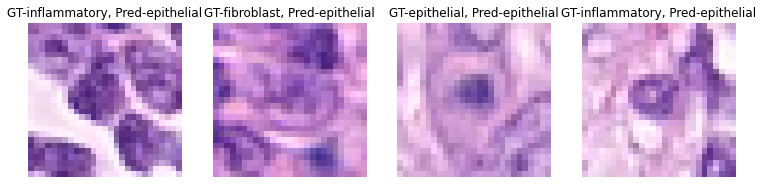

In [243]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in cell_test_generator:
        batches = batches + 1
        y_hat = cell_model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [244]:
cell_model.save("predict_celltype")

INFO:tensorflow:Assets written to: predict_celltype/assets
